# First steps

In [ ]:
import os
import torch
import re
import numpy as np
import json
import pandas as pd
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss, confusion_matrix
)
import tensorflow as tf
from tensorflow.keras import Model
import sys
sys.path.append('../sc')
from datapreprocesing import preprocess_data, create_dataloaders
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sktime.classification.kernel_based import RocketClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
import numpy as np
import tensorflow as tf
from statsmodels.tsa.ar_model import AutoReg
from sktime.classification.deep_learning import InceptionTimeClassifier

import torch

C:\Users\Lidia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

<!-- # Bootstrap and evaluation -->

## 1. Bootstrap

In [21]:
def bootstrap_ci(y_true, y_pred, metric_fn, n_boot=1000, ci=0.95):
    metrics = []
    n = len(y_true)
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    for _ in range(n_boot):
        idxs = np.random.choice(n, n, replace=True)
        y_true_sample = y_true[idxs]
        y_pred_sample = y_pred[idxs]
        metrics.append(metric_fn(y_true_sample, y_pred_sample))

    lower = np.percentile(metrics, (1 - ci) / 2 * 100)
    upper = np.percentile(metrics, (1 + ci) / 2 * 100)
    return lower, upper

# 2. Metrics graphs and tables

Code to extract from each metrics report the values and print it as tables and figutes for easly analysis

In [12]:

# --- CONFIGURACIÓN ---
checkpoint_dir = "../models/final_checkpoints/radon_data"
# Métricas que vamos a plotear
#regression_metrics = ["mae", "mse", "r2_score"]
classification_metrics = ["precision", "recall", "f1_score", "brier_score"]
soft_metrics = ["precision_soft", "recall_soft", "f1_soft"]
cost_metrics = ["trainable_params", "model_size_MB", "FLOPs"]

# Ejes Y de cada tipo de gráfica
y_limits = {
    "regression": None,  # pueden ser diferentes para cada eje
    "classification": (0, 1),
    "soft": (0, 1)
}


In [13]:
def extract_metrics_from_report(report_path):
    with open(report_path, "r") as f:
        data = json.load(f)
    return data.get("test_metrics", {}), data.get("soft_metrics", {}), data.get("computational_cost",{})

def collect_model_data():
    """Recorre carpetas y busca metrics_report.json en cada una"""
    model_data = {}
    for folder_name in os.listdir(checkpoint_dir):
        folder_path = os.path.join(checkpoint_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue

        # Buscar archivos que terminan en metrics_report.json
        for fname in os.listdir(folder_path):
            if fname.endswith("_report.json"): #metrics_with_soft
                report_path = os.path.join(folder_path, fname)
                test_metrics, soft_metrics_data, cost_metrics_data = extract_metrics_from_report(report_path)

                if not test_metrics:
                    print(f"Warning: no test metrics in {folder_name}")
                    continue

                model_data[folder_name] = {}
                # Test metrics
                for m in classification_metrics:
                    if m in test_metrics:
                        model_data[folder_name][m] = test_metrics[m]
                        ci = test_metrics.get(f"{m}_95ci", [test_metrics[m], test_metrics[m]])
                        model_data[folder_name][f"{m}_ci"] = ci
                # Soft metrics
                for m in soft_metrics:
                    if m in soft_metrics_data:
                        model_data[folder_name][m] = soft_metrics_data[m]
                        ci_lower = soft_metrics_data.get(f"{m}_ci_lower", soft_metrics_data[m])
                        ci_upper = soft_metrics_data.get(f"{m}_ci_upper", soft_metrics_data[m])
                        model_data[folder_name][f"{m}_ci"] = [ci_lower, ci_upper]
                for m in cost_metrics:
                    if m in cost_metrics_data:
                        model_data[folder_name][m] = cost_metrics_data[m]
    
    print(f"Found models: {list(model_data.keys())}")
    return model_data

In [21]:
def print_metrics_table(model_data):
    """
    Converts the nested dict of model metrics into a pandas DataFrame
    with models as rows and metrics (including CI) as columns.
    """
    rows = []
    for model_name, metrics in model_data.items():
        row = {"Model": model_name}
        for metric, value in metrics.items():
            # If it's a list/CI, format both values
            if isinstance(value, (list, tuple)) and len(value) == 2:
                row[metric] = f"[{value[0]:.3f}, {value[1]:.5f}]"
            else:
                row[metric] = f"{value:.5f}" if isinstance(value, (int, float)) else str(value)
        rows.append(row)

    df = pd.DataFrame(rows)
    df = df.set_index("Model")
    print(df.to_string())



In [22]:
def print_relative_metrics(model_data, metrics=None):
    """
    Prints a DataFrame of metrics relative to the `_base` model.
    
    Args:
        model_data: dict of model_name -> dict of metric -> value or [value, CI]
        metrics: list of metrics to include (if None, all numeric metrics are included)
    """
    import pandas as pd

    # Identify _base models
    base_models = {name: data for name, data in model_data.items() if name.endswith("_base")}
    if not base_models:
        raise ValueError("No base model found (model name must end with '_base')")

    # For simplicity, assume one base per model prefix
    # Map base prefix to base metrics
    base_prefix_map = {name.rsplit("_", 1)[0]: data for name, data in base_models.items()}

    rows = []
    for model_name, data in model_data.items():
        prefix = model_name.rsplit("_", 1)[0]
        if prefix not in base_prefix_map:
            continue  # skip if no base
        base_data = base_prefix_map[prefix]

        row = {"Model": model_name}
        for metric, value in data.items():
            if metrics is not None and metric not in metrics:
                continue
            # Ignore CI, take first if value is list/tuple
            v = value[0] if isinstance(value, (list, tuple)) else value
            base_v = base_data[metric][0] if isinstance(base_data[metric], (list, tuple)) else base_data[metric]
            # Compute relative to base
            row[metric] = v- base_v if base_v != 0 else float('nan')
        rows.append(row)

    df = pd.DataFrame(rows).set_index("Model")
    print(df.to_string(float_format="{:.5f}".format))

In [23]:
checkpoint_dir = "../models/checkpoints/radon_data"
model_data = collect_model_data()
print_metrics_table(model_data)

Found models: ['RG1DCBN_base', 'RG1DCMP_base', 'RG1DCRes_base', 'RG1DC_base', 'RG1DC_F16_base', 'RG1DC_F4_base', 'RG1DC_fc12_base', 'RG1DC_fc3_base', 'RG1DC_lb24_base', 'RG1DC_lb6_base', 'RG1DC_ndp_base', 'RG2DCBN_base', 'RG2DCMP_base', 'RG2DCRes_base', 'RG2DC_base', 'RG2DC_F16_base', 'RG2DC_F4_base', 'RG2DC_fc12_base', 'RG2DC_fc3_base', 'RG2DC_lb24_base', 'RG2DC_lb6_base', 'RG2DC_ndp_base']
                precision      precision_ci   recall         recall_ci f1_score       f1_score_ci brier_score    brier_score_ci precision_soft precision_soft_ci recall_soft    recall_soft_ci  f1_soft        f1_soft_ci trainable_params model_size_MB    FLOPs
Model                                                                                                                                                                                                                                                            
RG1DCBN_base      0.71204  [0.647, 0.77500]  0.95105  [0.910, 0.98218]  0.81437  [0.814, 

# 3. Baseline models

Raw

In [6]:
for file in ["../data/RG1.csv", "../data/RG2.csv"]:
    print(f"\n\nRunning pipeline for {file}")
    (X_train, y_train, y_train_bin, w, w2), (X_val, y_val, y_val_bin, w, w2), (X_test, y_test, y_test_bin, w, w2), scaler, scaler1, train_std = preprocess_data(file)
    y1=0
    yl=0
    for y_bin in [y_train_bin, y_val_bin, y_test_bin]:
        y1+=sum(y_bin)
        yl+=len(y_bin)
        print("proportion y=1", sum(y_bin)/len(y_bin))
    print(f"for {file}", y1/yl)



Running pipeline for ../data/RG1.csv
Original y = 75.0 -> Scaled y = 0.013719303059404582
Original y = 255.0 -> Scaled y = 2.4831938537522293
Original y = 270.0 -> Scaled y = 2.688983399643298
Original y = 285.0 -> Scaled y = 2.894772945534367
Original y = 300.0 -> Scaled y = 3.1005624914254355
Original y = 600.0 -> Scaled y = 7.2163534092468105
y_bin_train_seq: 8 transitions (0→1)
y_bin_train_seq: 7 transitions (1→0)
y_bin_val_seq: 5 transitions (0→1)
y_bin_val_seq: 5 transitions (1→0)
y_bin_test_seq: 4 transitions (0→1)
y_bin_test_seq: 4 transitions (1→0)
proportion y=1 0.03348992271556296
proportion y=1 0.14043583535108958
proportion y=1 0.07183212267958031
for ../data/RG1.csv 0.05332158202049135


Running pipeline for ../data/RG2.csv
Original y = 75.0 -> Scaled y = -0.2154696132596685
Original y = 255.0 -> Scaled y = 0.7790055248618785
Original y = 270.0 -> Scaled y = 0.861878453038674
Original y = 285.0 -> Scaled y = 0.9447513812154696
Original y = 300.0 -> Scaled y = 1.02762430

In [ ]:

def compute_metrics(y_true, y_pred, y_pred_proba):
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "precision_ci": bootstrap_ci(y_true, y_pred, precision_score), 
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "recall_ci": bootstrap_ci(y_true, y_pred, recall_score), 
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "f1_ci": bootstrap_ci(y_true, y_pred, f1_score), 
        "brier": brier_score_loss(y_true, y_pred_proba),
        "brier_ci": bootstrap_ci(y_true, y_pred, brier_score_loss)
    }

def flatten_X(X):
    B = X.shape[0]
    return X.reshape(B, -1)

def ar1_predict(X_series, threshold):
    """Predicción AR(1) por muestra"""
    y_pred_bin = []
    for x in X_series:
        model = AutoReg(x, lags=1, old_names=False)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(x), end=len(x))
        y_pred_bin.append(int(pred >= threshold))
    return np.array(y_pred_bin)


In [ ]:

def get_keras_model(clf):
    """
    Return the underlying Keras model inside sktime's classifier.
    For InceptionTimeClassifier (Keras backend), clf.model_ IS the keras.Model.
    """
    model = getattr(clf, "model_", None)
    if isinstance(model, Model):
        return model
    else:
        raise ValueError("Could not locate a Keras model inside the classifier.")

def count_trainable_params_keras(model):
    """Count only trainable parameters of a Keras model."""
    return int(np.sum([np.prod(w.shape) for w in model.trainable_weights]))

def model_size_mb_keras(model, bytes_per_param=4):  # float32 → 4 bytes
    params = count_trainable_params_keras(model)
    return params * bytes_per_param / (1024 ** 2)

def compute_flops_keras(model, X_sample_numpy):
    """
    Compute FLOPs using TensorFlow's built-in profiler.
    Works in TF 2.9+ (and most 2.x versions).
    Returns None if not supported.
    """
    try:
        concrete = tf.function(model).get_concrete_function(
            tf.TensorSpec(X_sample_numpy.shape, tf.float32)
        )

        # Run TF profiler
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(
            graph=concrete.graph,
            run_meta=run_meta,
            options=opts
        )

        return flops.total_float_ops if flops is not None else None

    except Exception as e:
        print("⚠ TensorFlow could not compute FLOPs:", e)
        return None


def model_report(clf, X_sample_numpy):
    model = get_keras_model(clf)

    # Make sure the sample is batch-shaped: (1, C, L)
    if X_sample_numpy.ndim == 2:
        X_sample_numpy = X_sample_numpy[np.newaxis, :, :]

    print("============== MODEL REPORT (Keras) ==============")
    print("Trainable parameters:", count_trainable_params_keras(model))
    print("Model size (MB):    ", model_size_mb_keras(model))

    flops = compute_flops_keras(model, X_sample_numpy)
    if flops is not None:
        print("FLOPs:               ", flops)
    else:
        print("FLOPs:               Not available")

    print("===================================================")

In [ ]:
for file in ["../data/RG1.csv", "../data/RG2.csv"]:
    print(f"\n\nRunning pipeline for {file}")
    
    try:
        threshold = 200 if "RG1" in file else 300

        (X_train, _, y_train_bin, _, _), \
        (X_val, _, y_val_bin, _, _), \
        (X_test, _, y_test_bin, _, _), \
        _, _, _ = preprocess_data(
            file, lookback=12, forecast=3, threshold=threshold
        )

        # Proporción de positivos
        for name, y_bin in zip(["train", "val", "test"], [y_train_bin, y_val_bin, y_test_bin]):
            print(f"proportion y=1 ({name}) =", sum(y_bin)/len(y_bin))

        X_train_flat = flatten_X(X_train)
        X_test_flat  = flatten_X(X_test)

        X_train_3d = X_train
        X_test_3d = X_test

        models = {
            "LogisticRegression (Flat)": LogisticRegression(max_iter=2000, solver='liblinear'),
            "RandomForest (Flat)": RandomForestClassifier(n_estimators=100),
            "KNN (Euclidean Flat)": KNeighborsClassifier(n_neighbors=5)
        }

        print("\n--- Running Tabular Baselines ---")
        for name, clf in models.items():
            clf.fit(X_train_flat, y_train_bin)
            y_pred = clf.predict(X_test_flat)
            y_proba = clf.predict_proba(X_test_flat)[:, 1] if hasattr(clf, "predict_proba") else y_pred
            metrics = compute_metrics(y_test_bin, y_pred, y_proba)
            print(f"{name} Metrics:", metrics)

        print("\n--- Running AR(1) Baseline ---")
        # Tomamos la primera característica
        X_test_series = X_test[:, :, 0]
        y_pred_ar1 = ar1_predict(X_test_series, threshold)
        y_proba_ar1 = y_pred_ar1
        metrics_ar1 = compute_metrics(y_test_bin, y_pred_ar1, y_proba_ar1)
        print(f"AR(1) Baseline Metrics:", metrics_ar1)

        print("\n--- Running Time Series Specific Baselines ---")
        X_train_3d_sktime = X_train.transpose(0, 2, 1)
        X_test_3d_sktime = X_test.transpose(0, 2, 1)

        try:
            print("InceptionTime Classifier...")
            inception_clf = InceptionTimeClassifier(
                n_epochs=500,
                random_state=42,
                verbose=False # Set to True for detailed training output
            )
            
            inception_clf.fit(X_train_3d_sktime, y_train_bin)
            y_pred_inception = inception_clf.predict(X_test_3d_sktime)
            y_proba_inception = inception_clf.predict_proba(X_test_3d_sktime)[:, 1]
            
            # Compute metrics using your custom function
            metrics_inception = compute_metrics(y_test_bin, y_pred_inception, y_proba_inception)
            print(f"InceptionTime Classifier Metrics 500ep:", metrics_inception)
            
            inception_clf = InceptionTimeClassifier(
                n_epochs=100,
                random_state=42,
                verbose=False # Set to True for detailed training output
            )
            
            inception_clf.fit(X_train_3d_sktime, y_train_bin)
            
            y_pred_inception = inception_clf.predict(X_test_3d_sktime)
            y_proba_inception = inception_clf.predict_proba(X_test_3d_sktime)[:, 1]

            metrics_inception = compute_metrics(y_test_bin, y_pred_inception, y_proba_inception)
            print(f"InceptionTime Classifier Metrics 100 ep:", metrics_inception)
            
        except Exception as e:
            print(f"InceptionTime Classifier falló: {e}")


    except FileNotFoundError:
        print(f"Error: {file} not found. Please check the file path.")



Running pipeline for ../data/RG1.csv
Original y = 50.0 -> Scaled y = -0.32926327342571
Original y = 170.0 -> Scaled y = 1.31705309370284
Original y = 180.0 -> Scaled y = 1.4542461242968856
Original y = 190.0 -> Scaled y = 1.5914391548909315
Original y = 200.0 -> Scaled y = 1.7286321854849773
Original y = 400.0 -> Scaled y = 4.472492797365894
y_bin_train_seq: 21 transitions (0→1)
y_bin_train_seq: 20 transitions (1→0)
y_bin_val_seq: 10 transitions (0→1)
y_bin_val_seq: 10 transitions (1→0)
y_bin_test_seq: 10 transitions (0→1)
y_bin_test_seq: 9 transitions (1→0)
proportion y=1 (train) = 0.09256538348516015
proportion y=1 (val) = 0.2351313969571231
proportion y=1 (test) = 0.12240663900414937

--- Running Tabular Baselines ---
LogisticRegression (Flat) Metrics: {'precision': 0.9354838709677419, 'precision_ci': (0.8917135732977831, 0.9716362001798021), 'recall': 0.8192090395480226, 'recall_ci': (0.7643597442851608, 0.8727299001576457), 'f1': 0.8734939759036144, 'f1_ci': (0.834391385438294, 

In [ ]:
X_train_fixed = np.transpose(X_train_3d_sktime, (0, 2, 1))
sample_fixed = X_train_fixed[0].reshape(1, 12, 1)
model_report(inception_clf,sample_fixed)

============== MODEL REPORT (Keras) ==============
Trainable parameters: 420450
Model size (MB):     1.6038894653320312
FLOPs:                10094384


# 4. Cost and safety violations

In [3]:
# --- MODELOS RG1 / RG2 (R2C) ---
model_args_a = {
    'input_size': 1,
    'hidden_size': 16,
    'num_layers': 2,
    'forecast_len': 6,
    'lookback': 12,
}

model1a = models.SerializableModule().create("DC", **model_args_a)
model1a.load_state_dict(
    torch.load("../models/checkpoints/radon_data/RG1DC_base/_base.pt",
               map_location='cpu'),
    strict=False
)

model2a = models.SerializableModule().create("DC", **model_args_a)
model2a.load_state_dict(
    torch.load("../models/checkpoints/radon_data/RG2DC_base/_base.pt",
               map_location='cpu'),
    strict=False
)

model1b = models.SerializableModule().create("R2C", **model_args_a)
model1b.load_state_dict(
    torch.load("../models/checkpoints/radon_data/RG1R2C_base/_base.pt",
               map_location='cpu'),
    strict=False
)

model2b = models.SerializableModule().create("R2C", **model_args_a)
model2b.load_state_dict(
    torch.load("../models/checkpoints/radon_data/RG2R2C_base/_base.pt",
               map_location='cpu'),
    strict=False
)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['total_ops', 'total_params'])

In [ ]:
(X_train1, y_train1, y_train_bin1, w11, w12), \
(X_val1, y_val1, y_val_bin1, w11v, w12v), \
(X_test1, y_test1, y_test_bin1, w11t, w12t), \
scaler1, scaler_y1, train_std1 = preprocess_data(
    "../data/RG1.csv", testonly=True, lookback=12, forecast=6, threshold=200, scaler_path="../notebooks/RG2_scaler.pkl"
)

_, _, test_loader1 = create_dataloaders(
    X_train1, y_train1, y_train_bin1, w11, w12,
    X_val1, y_val1, y_val_bin1, w11v, w12v,
    X_test1, y_test1, y_test_bin1, w11t, w12t,
    scaler=scaler1, train_std=train_std1, batch_size=1, shuffle=False
)

# --- RG2 ---
(X_train2, y_train2, y_train_bin2, w21, w22), \
(X_val2, y_val2, y_val_bin2, w21v, w22v), \
(X_test2, y_test2, y_test_bin2, w21t, w22t), \
scaler2, scaler_y2, train_std2 = preprocess_data(
    "../data/RG2.csv", testonly=True, lookback=12, forecast=6, threshold=300, scaler_path="../notebooks/RG2_scaler.pkl"
)

_, _, test_loader2 = create_dataloaders(
    X_train2, y_train2, y_train_bin2, w21, w22,
    X_val2, y_val2, y_val_bin2, w21v, w22v,
    X_test2, y_test2, y_test_bin2, w21t, w22t,
    scaler=scaler2, train_std=train_std2, batch_size=1, shuffle=False
)


In [5]:

def trend_hysteresis(y_pred, threshold_low=0.3, threshold_up=0.7, trend_len=3, slope_vals=0.05):
    """
    Histeresis basada en pendiente de y_pred.

    Args:
        y_pred (array-like): Predicciones continuas.
        threshold_low (float): Umbral mínimo para hard decision.
        threshold_up (float): Umbral máximo para hard decision.
        trend_len (int): Número de activaciones consecutivas para desactivar.
        slope_vals (float): Umbral de pendiente para activar/desactivar.

    Returns:
        y_bin (np.array): Señal binaria siguiendo la lógica de pendiente.
    """
    y_pred = np.asarray(y_pred)
    n = len(y_pred)
    y_bin = np.zeros(n, dtype=int)
    m_pos = 0
    m_neg = 0
    m_nonfix = 0
    print(slope_vals)

    y_pred = np.asarray(y_pred)
    n = len(y_pred)
    y_bin = np.zeros(n, dtype=int)
    active = bool(round(y_pred[0]))  
    print("active", active)# inicializamos según primer valor
    count_active = 0

    for i in range(1, n):
        val = y_pred[i]
        prev = y_pred[i-1]
        slope = val - prev

        start_idx = max(0, i - trend_len + 1)
        trend_window = y_pred[start_idx:i+1]
        slopes_trend = np.diff(trend_window)

        # --- Activación / Desactivación ---
        if val > threshold_up:  # hard activation
            active = True
            count_active += 1
        elif val < threshold_low:  # hard deactivation
            active = False
            count_active = 0
        else:
            # pendiente positiva → activar
            if slope > slope_vals:
                active = True
                count_active += 1
            # pendiente negativa → desactivar
            elif slope < -slope_vals:
                active = False
                count_active = 0
            # si no cumple ninguna, mantener estado
            else:
                if active:
                    count_active += 1
                else:
                    count_active = 0

        # Asignar valor binario
        y_bin[i] = int(active)

    print("Non-fixed:", m_nonfix, "Positives:", m_pos, "Negatives:", m_neg)
    return y_bin


In [32]:
def fixed(y_pred, threshold_low=0.3, threshold_up=0.7, trend_len=3, slope_vals=0.05):
    """
    Histeresis basada en pendiente de y_pred.

    Args:
        y_pred (array-like): Predicciones continuas.
        threshold_low (float): Umbral mínimo para hard decision.
        threshold_up (float): Umbral máximo para hard decision.
        trend_len (int): Número de activaciones consecutivas para desactivar.
        slope_vals (float): Umbral de pendiente para activar/desactivar.

    Returns:
        y_bin (np.array): Señal binaria siguiendo la lógica de pendiente.
    """
    y_pred = np.asarray(y_pred)
    n = len(y_pred)
    y_bin = np.zeros(n, dtype=int)
    m_pos = 0
    m_neg = 0
    m_nonfix = 0
    print(slope_vals)

    y_pred = np.asarray(y_pred)
    n = len(y_pred)
    y_bin = np.zeros(n, dtype=int)
    active = bool(round(y_pred[0]))  
    y_bin[0]=int(active)
    print("active", active)# inicializamos según primer valor
    count_active = 0

    for i in range(1, n):
        val = y_pred[i]
       
        if val >= 0.5:  # hard activation
            active = True
            count_active += 1
        elif val < 0.35:  # hard deactivation
            active = False
            count_active = 0


        # Asignar valor binario
        y_bin[i] = int(active)

    print("Non-fixed:", m_nonfix, "Positives:", m_pos, "Negatives:", m_neg)
    return y_bin


In [ ]:
def grid_search_smoothing(y_true, y_pred_cl, y_inv, threshold, max_cost, max_viol):
    """
    Performs grid search for smoothing parameters in hysteresis mode,
    but only considers combinations that stay below max_cost and max_viol.
    
    modes = ["trend", "slope_seq", "consistency", "strong_slope", "mean",
             "momentum", "threshold_ratio", "peak_detection",
             "trend_up", "slope_seq_up", "consistency_up", "strong_slope_up",
             "mean_up", "momentum_up", "threshold_ratio_up", "peak_detection_up"]
    """

    modes = ["trendhysteresis"]
    # Candidate parameter ranges
    threshold_pairs = [
        (0.5, 0.35),
    ]
    trend_vals = [3]
    slope_vals = [0.025, 0.05, 0.10, 0.15]

    N = len(y_pred_cl)
    best_global = {"mode": "trendhysteresis", "params": dict(
                        threshold_up=0.5,
                        threshold_low=0.2,
                        trend_len=2,
                        slope_vals=0.05,
                    ), "score": np.inf, "y_bin": None}
    
    thfixeds = [0.3, 0.33, 0.35, 0.4, 0.45, 0.5]
    for th_fixed in thfixeds: 
        
        unsafe_AI_unsavable = np.where(
            (y_pred_cl < th_fixed) & (np.any(y_inv[:, 0:3] > threshold, axis=1))
        )[0]
        cost_AI =np.sum(y_pred_cl > th_fixed) / N

        print(f"thr_fixed={th_fixed:.2f}: sec {len(unsafe_AI_unsavable)}, cost {cost_AI}")
    
    for mode in modes:
        for thr_up, thr_low in threshold_pairs:
            above_up = y_pred_cl >= thr_up
            below_low = y_pred_cl <= thr_low

            # False positives at the high end (pred high, true = 0)
            fp_high = np.sum(above_up & (y_true == 0))

            # False negatives at the low end (pred low, true = 1)
            fn_low = np.sum(below_low & (y_true == 1))
            
            unsafe_AI_savable = np.where(
                (y_pred_cl < thr_up) & (np.any(y_inv[:, 0:3] > threshold, axis=1))
            )[0]
            
            unsafe_AI_unsavable = np.where(
                (y_pred_cl < thr_low) & (np.any(y_inv[:, 0:3] > threshold, axis=1))
            )[0]

            cost_min=np.sum(y_pred_cl > thr_up) / len(y_pred_cl)
            between = np.sum((y_pred_cl < thr_up) & (y_pred_cl > thr_low))
            print(f"thr_up={thr_up:.2f} thr_low={thr_low:.2f}  | "
                f"unsafe_changeble= {len(unsafe_AI_savable)}, unsafe_problem={len(unsafe_AI_unsavable)}, fixed_cost {cost_min:.4f}, margin instances: {between}")
            
            print("Unsafe AI Savable details:")
            for idx in unsafe_AI_savable:
                print(f"Index: {idx}, y_pred_cl: {y_pred_cl[idx-2:idx+1]}")
    
            for trend_len in trend_vals:
                for slope in slope_vals:
                    # Only pass relevant parameters to each mode
                    kwargs = dict(
                        threshold_up=thr_up,
                        threshold_low=thr_low,
                        trend_len=trend_len,
                        slope_vals=slope,
                        #mode=mode
                    )

                    #y_bin = smooth_binary_predictions(y_pred_cl, **kwargs)
                    y_bin = fixed(y_pred_cl, **kwargs)

                    # Compute cost and violations
                    cost_AI = np.sum(y_bin) / N
                    unsafe_AI = np.where(
                        (y_bin == 0) & (np.any(y_inv[:, 0:3] > threshold, axis=1))
                    )[0]
                    violations = len(unsafe_AI)

                    # Only consider feasible combinations
                    if cost_AI < max_cost and violations < max_viol:
                        score = cost_AI + violations
                        print(f"POSIBLE → Mode: {mode}, Params: {kwargs}, Score: {score:.4f}, "
                                    f"Cost: {cost_AI:.4f}, Violations: {violations}")
                        if score <= best_global["score"]:
                            best_global.update({
                                "mode": mode,
                                "params": kwargs,
                                "score": score,
                                "y_bin": y_bin
                            })
                            print(f"NEW BEST → Mode: {mode}, Params: {kwargs}, Score: {score:.4f}, "
                                    f"Cost: {cost_AI:.4f}, Violations: {violations}")

    return best_global["mode"], best_global["params"]

In [6]:
import joblib
scaler_path1 = "RG1_scaler.pkl"
scaler_path2 = "RG2_scaler.pkl"
with open(scaler_path1, "rb") as f:
    scaler_y1 = joblib.load(f)
with open(scaler_path2, "rb") as f:
    scaler_y2 = joblib.load(f)

In [ ]:
import seaborn as sns

names = ["RG1-DC", "RG1-R2C", "RG2-DC", "RG2-R2C"]
test_loaders = [test_loader1,  test_loader1, test_loader2, test_loader2]  # map models to loaders
models = [model1a, model1b, model2a, model2b]
scalers =[scaler_y1, scaler_y1, scaler_y2, scaler_y2]
thresholds= [200, 200, 300, 300]
durations = [4, 4, 3, 3]


results = {}

for name, loader, model, scaler_y, threshold, duration in zip(names, test_loaders, models, scalers, thresholds, durations):
    print(f"\n=== Running predictions for {name} ===")
    
    model.eval()
    test_preds_reg, test_preds_cl = [], []
    test_targets_reg, test_targets_cl = [], []
    
    with torch.no_grad():
        for X_test_batch, y_test_batch, y_test_batch_bin, w_cl_batch, w_reg_batch in loader:
            outputs_reg, outputs_cl = model(X_test_batch)
            
            test_preds_reg.append(outputs_reg.cpu())
            test_targets_reg.append(y_test_batch.cpu())
            
            test_preds_cl.append(outputs_cl.cpu())
            test_targets_cl.append(y_test_batch_bin.cpu())
    
    # Concatenate
    test_preds_reg = torch.cat(test_preds_reg).squeeze()
    test_targets_reg = torch.cat(test_targets_reg).squeeze()
    
    test_preds_cl = torch.cat(test_preds_cl).squeeze()
    test_targets_cl = torch.cat(test_targets_cl).squeeze()
    
    # Convert to numpy
    y_pred_reg = test_preds_reg.numpy()
    y_true_reg = test_targets_reg.numpy()
    
    y_pred_cl = torch.sigmoid(test_preds_cl).numpy()
    y_true_bin = test_targets_cl.numpy()
    
    preds_pos = y_pred_cl[y_true_bin == 1]
    preds_neg = y_pred_cl[y_true_bin == 0]


    # Create figure with 2 subplots
    fig, ax = plt.subplots(1, 1, figsize=(7, 3))

    sns.kdeplot(preds_neg, fill=True, color='blue', alpha=0.4, label='y_true = 0', ax=ax)
    sns.kdeplot(preds_pos, fill=True, color='red', alpha=0.4, label='y_true = 1', ax=ax)

    ax.axvline(0.4, color='gray', linestyle='--')
    ax.axvline(0.6, color='gray', linestyle='--')
    ax.axvline(0.5, color='black', linestyle='--')

    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Density')

    plt.show()
   

    N, steps = y_true_reg.shape
    y_reshape = y_true_reg.reshape(-1, 1)

    y_inv = scaler_y.inverse_transform(y_reshape).reshape(N, steps)
    
    if "DC" in name:
    # Run grid search only for DC
        if "RG1" in name:
            mode, kwargs = grid_search_smoothing(
                y_true_bin, y_pred_cl, y_inv, threshold, 
                max_cost=0.1598, max_viol=47
            )
        else:
            mode, kwargs = grid_search_smoothing(
                y_true_bin, y_pred_cl, y_inv, threshold, 
                max_cost=0.3163, max_viol=38
            )

        # store parameters for future models
        last_dc_mode = mode
        last_dc_kwargs = kwargs

    else:
        # For NON-DC models → use previous DC parameters
        if last_dc_mode is None:
            raise RuntimeError("DC parameters not computed yet!")

        mode = last_dc_mode
        kwargs = last_dc_kwargs

    print(kwargs)

    y_bin_pred = fixed(y_pred_cl, **kwargs)
    
    y_bin_AI = y_bin_pred.copy()
    y_bin_AI_real = y_true_bin.copy()
    y_bin_RS = np.zeros_like(y_bin_AI)

    # Cálculo de derivada aproximada
    diff = np.zeros_like(y_inv[:, 0])
    diff[1:] = (y_inv[1:, 0] - y_inv[:-1, 0]) / 10.0

    # Sistema de reglas
    for i in range(1, len(y_inv)):
        if (y_inv[i, 0] > threshold or 
            (y_inv[i, 0] > (2/3) * threshold and diff[i] > 0.3)):
            y_bin_RS[i] = 1
        elif y_inv[i, 0] > (2/3) * threshold and diff[i] > -0.3:
            y_bin_RS[i] = y_bin_RS[i-1]

    above_thr = np.sum(y_inv[:, 0] > threshold)
    transitions = np.sum((y_inv[1:, 0] > threshold) & (y_inv[:-1, 0] < threshold))
    sp = above_thr + 2 * transitions

    # Costes
    cost_RS = np.sum(y_bin_RS) / len(y_bin_RS)
    cost_AI = np.sum(y_bin_AI) / len(y_bin_AI)
    cost_real_IA = np.sum(y_bin_AI_real) / len(y_bin_AI_real)
    cost_min = sp / len(y_bin_AI)
    cost_min_per= above_thr / len(y_bin_AI)
    
    #violations
    
    def count_violation_episodes(y_bin, y_inv, threshold, onset_window=2, duration=4):

        n = len(y_bin)
        violations = []
        t = 0
        while t < n:
            if y_bin[t] == 0 and n>1:

                end = min(n, t + onset_window + 1)
                exceeds = np.any(y_inv[t:end, 0] > threshold)

                if exceeds:
                    violations.append(t)
                    t += duration   # skip ahead to avoid double counting
                    continue

            t += 1

        return np.array(violations)

    unsafe_RS      = count_violation_episodes(y_bin_RS,      y_inv, threshold, duration=duration)
    unsafe_AI      = count_violation_episodes(y_bin_AI,      y_inv, threshold, duration=duration)
    unsafe_AI_real = count_violation_episodes(y_bin_AI_real, y_inv, threshold, duration=duration)
    unsafe_per = transitions
    


    safety_RS = 1 - len(unsafe_RS) / len(y_true_reg)
    safety_AI = 1 - len(unsafe_AI) / len(y_true_reg)
    safety_AI_real = 1 - len(unsafe_AI_real) / len(y_true_reg)

    # Transiciones
    trans_RS = np.where((y_bin_RS[1:] == 1) & (y_bin_RS[:-1] == 0))[0] + 1
    trans_AI = np.where((y_bin_AI[1:] == 1) & (y_bin_AI[:-1] == 0))[0] + 1
    trans_AI_real = np.where((y_bin_AI_real[1:] == 1) & (y_bin_AI_real[:-1] == 0))[0] + 1

    val_RS = y_inv[trans_RS - 1, 0] if len(trans_RS) > 0 else []
    val_AI = y_inv[trans_AI - 1, 0] if len(trans_AI) > 0 else []
    val_AI_real = y_inv[trans_AI_real - 1, 0] if len(trans_AI_real) > 0 else []

    # Prints
    print(f"Coste RS: {cost_RS:.4f}, Coste AI: {cost_AI:.4f}, Coste AI real : {cost_real_IA:.4f}, Coste min: {cost_min:.4f}")
    print(f"Seguridad RS: {safety_RS:.4f}, Seguridad AI: {safety_AI:.4f}, Seguridad AI real: {safety_AI_real:.4f}; Seguridad max: 1.00")
    print(f"Violaciones RS: {len(unsafe_RS)}, Violaciones AI: {len(unsafe_AI)}, Violaciones AI real: {len(unsafe_AI_real)}")
    print(f"Transiciones RS: {trans_RS.tolist()}")
    print(f"Transiciones AI: {trans_AI.tolist()}")
    print(f"Transiciones AI real: {trans_AI_real.tolist()}")
    print(f"Indices UNSAFE_RS ({len(unsafe_RS)} casos): {unsafe_RS.tolist()}")
    print(f"Indices UNSAFE_AI ({len(unsafe_AI)} casos): {unsafe_AI.tolist()}")
    print(f"Indices UNSAFE_AI_REAL ({len(unsafe_AI_real)} casos): {unsafe_AI_real.tolist()}")
    print("Valores y_cl_all en UNSAFE_AI:", y_pred_cl[unsafe_AI].tolist())
    print("Valores y_inv en UNSAFE_AI:", y_inv[unsafe_AI].tolist())
    
    plt.figure(figsize=(6, 6))

    plt.scatter(cost_RS, len(unsafe_RS), color='orange', label='Rule System')
    plt.scatter(cost_AI, len(unsafe_AI), color='lightblue', label='AI Model')
    plt.scatter(cost_min_per, unsafe_per, color='royalblue', label='Persistence Model')
    plt.scatter(cost_min, 0, color='yellowgreen', label='Best Model')
    plt.xlabel('Cost')
    plt.ylabel('Security violations')
    plt.legend()
    plt.show()
    
    results[name] = {
    "cost_RS": cost_RS,
    "cost_AI": cost_AI,
    "cost_min_per": cost_min_per,
    "cost_min": cost_min,
    "unsafe_RS": unsafe_RS,
    "unsafe_AI": unsafe_AI,
    "unsafe_per": unsafe_per
    }


In [ ]:
# Leyendas personalizadas
from matplotlib.patches import Patch
methods = ["RS", "AI", "Persistence", "Best"]
colors = ["orange", "lightblue", "royalblue", "yellowgreen"]

# Example: each entry = (cost, safety violations)
G1 = []
G2 = []

for name in ["RG1-DC", "RG1-R2C", "RG2-DC", "RG2-R2C"]:
    r = results[name]
    entry = [
        (r["cost_RS"], len(r["unsafe_RS"])),
        (r["cost_AI"], len(r["unsafe_AI"])),
        (r["cost_min_per"], r["unsafe_per"]),
        (r["cost_min"], 0)
    ]
    
    if name.startswith("RG1"):
        G1.append(entry)
    else:
        G2.append(entry)

G1 = np.array(G1)  
G2 = np.array(G2)  

print(G1)

[[[ 0.15979434 33.        ]
  [ 0.14673522 15.        ]
  [ 0.09089974 58.        ]
  [ 0.10282776  0.        ]]

 [[ 0.15979434 33.        ]
  [ 0.28123393  6.        ]
  [ 0.09089974 58.        ]
  [ 0.10282776  0.        ]]]


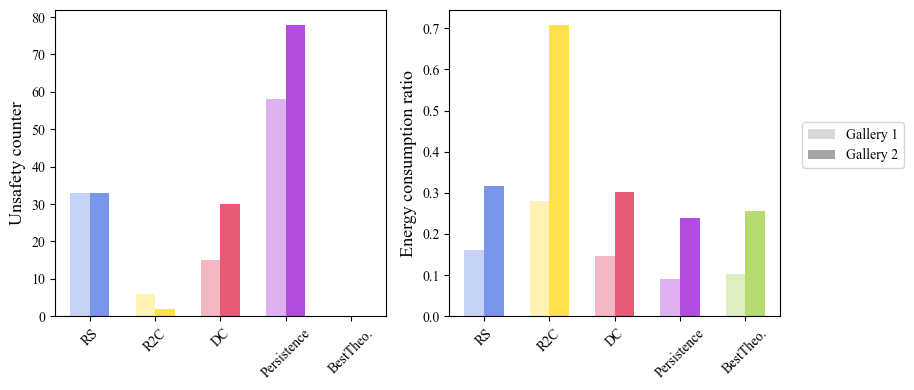

In [ ]:
methods = ["RS", "R2C", "DC", "Persistence", "BestTheo."]
colors  = ["royalblue", "gold", "crimson", "darkviolet", "yellowgreen"]
plt.rcParams['font.family'] = 'Times New Roman'
# Original mapping:
# RS          = G[0,0,*]
# DC          = G[0,1,*]
# Persistence = G[0,2,*]
# BestTheo    = G[0,3,*]
# R2C         = G[1,1,*]

# Reordered data: RS → R2C → DC → Persistence → BestTheo
violations_G1 = [
    G1[0, 0, 1],   # RS
    G1[1, 1, 1],   # R2C
    G1[0, 1, 1],   # DC
    G1[0, 2, 1],   # Persistence
    G1[0, 3, 1]    # BestTheo
]
violations_G2 = [
    G2[0, 0, 1],
    G2[1, 1, 1],
    G2[0, 1, 1],
    G2[0, 2, 1],
    G2[0, 3, 1]
]

cost_G1 = [
    G1[0, 0, 0],   # RS
    G1[1, 1, 0],   # R2C
    G1[0, 1, 0],   # DC
    G1[0, 2, 0],   # Persistence
    G1[0, 3, 0]    # BestTheo
]
cost_G2 = [
    G2[0, 0, 0],
    G2[1, 1, 0],
    G2[0, 1, 0],
    G2[0, 2, 0],
    G2[0, 3, 0]
]

print(violations_G1, violations_G2, cost_G1, cost_G2)
x = np.arange(len(methods))  # posiciones
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].bar(x - 0.15, violations_G1, width=0.3, color=colors, label='Gallery 1', alpha=0.3) 
axs[0].bar(x + 0.15, violations_G2, width=0.3, color=colors, alpha=0.7, label='Gallery 2') 
axs[0].set_ylabel("Unsafety counter", fontsize=13) 
axs[0].set_xticks(x) 
axs[0].set_xticklabels(methods, rotation=45)

axs[1].bar(x - 0.15, cost_G1, width=0.3, color=colors, label='Gallery 1', alpha=0.3) 
axs[1].bar(x + 0.15, cost_G2, width=0.3, color=colors, label='Gallery 2', alpha=0.7)
axs[1].set_ylabel("Energy consumption ratio", fontsize=13) 
axs[1].set_xticks(x) 
axs[1].set_xticklabels(methods, rotation=45)

legend_elements = [ Patch(facecolor='gray', alpha=0.3, label='Gallery 1'), 
                   Patch(facecolor='gray', alpha=0.7, label='Gallery 2') ]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.0, 0.7), ncol=1)
plt.tight_layout() 
plt.show()
